In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import sys
from pathlib import Path

ROOT_DIR = Path.cwd().parents[0]
sys.path.append(str(ROOT_DIR))

from src.preprocessing import preprocess_data


# loading our train data

train_path = ROOT_DIR / "data" / "raw" / "train.csv"

train_data = pd.read_csv(train_path, index_col='id')

# taking our target column as y
y = train_data['diagnosed_diabetes']
X = train_data.drop(columns="diagnosed_diabetes")

# print(X.head(5))

# extracting categorical and numkerical columns

cat_cols = [col for col in X.columns if X[col].dtype == 'object']

num_cols = [col for col in X.columns if X[col].dtype == 'int64' or X[col].dtype == 'float64']

#print(cat_cols, num_cols)

#Splitting our data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=1)
#print(X_train.shape, "\n", X_valid.shape)

#Creatin A column Tranformer for preprocessing the data

ordinal_cat_cols = ["education_level", "income_level"]
nominal_cat_cols = ["gender", "ethnicity","smoking_status","employment_status"]


In [13]:
# Building RandomForest model and checking its performance

processing = preprocess_data(num_cols=num_cols, ordinal_cat_cols=ordinal_cat_cols, nominal_cat_cols=nominal_cat_cols)

forest_model = RandomForestClassifier(n_estimators=300, random_state=1, max_depth=None, min_samples_leaf=20)

forest_pipeline = Pipeline(steps=[("preprocessing", processing),
                                  ("random_forest",forest_model)])

forest_pipeline.fit(X_train, y_train)

y_pred = forest_pipeline.predict_proba(X_valid)[:,1]

print(y_pred.shape)


(140000,)


In [14]:
# Calculating metrics

roc_auc = roc_auc_score(y_valid, y_pred)

ll = log_loss(y_valid, y_pred)

y_pred_label = (y_pred >= 0.6).astype(int)
conf_mtx = confusion_matrix(y_valid, y_pred_label)

print("ROC_AUC Score: ", roc_auc)
print("Log_loss Score: ", ll)
print("Confusion Matrix: \n")
print(conf_mtx)

ROC_AUC Score:  0.7005431803676769
Log_loss Score:  0.5999088490511203
Confusion Matrix: 

[[32821 19701]
 [30069 57409]]


In [15]:
# using gradient descent model

hist_grad_model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, max_depth=6, random_state=1)

hist_grad_pipeline = Pipeline(steps=[("preprocessing", processing),
                                     ("hist_gradient_descent", hist_grad_model)])

hist_grad_pipeline.fit(X_train,y_train)
y_pred_hgd = hist_grad_pipeline.predict_proba(X_valid)[:,1]

print("Done")

Done


In [23]:
#Calculating metrics for Gradient Descent model

roc_auc_gd = roc_auc_score(y_valid, y_pred_hgd)
ll_gd = log_loss(y_valid, y_pred_hgd)

y_pred_label_gd = (y_pred >= 0.51).astype(int)
conf_mtx_gd = confusion_matrix(y_valid, y_pred_label_gd)

print("ROC_AUC Score using Gradient Descent Model: ", roc_auc_gd)
print("Log_loss Score: ", ll_gd)
print("Confusion Matrix: \n")
print(conf_mtx_gd)

ROC_AUC Score using Gradient Descent Model:  0.7193797419925901
Log_loss Score:  0.5876971048905953
Confusion Matrix: 

[[19080 33442]
 [13166 74312]]


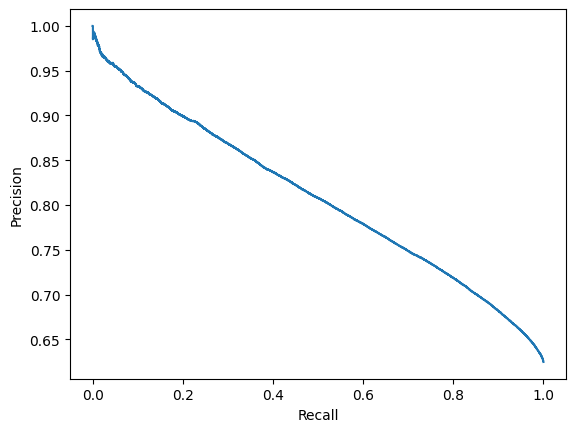

In [19]:
# Plotting PR curve for the Gradient Descent Model
prec_gd, recall_gd, threshold_gd = precision_recall_curve(y_valid, y_pred_hgd)

plt.figure()
plt.plot(recall_gd, prec_gd)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()